<a href="https://colab.research.google.com/github/diidouu/SLAM-PROJECT/blob/main/projectRobotic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bayesian Filtering Project : Simultaneous SLAM (Localization and Cartography) - EKF**
# 1. Problem definition :
The SLAM challenge can be seen as the *'chicken and egg problem'* :


*   To build a precise map of an unknown environment, a robot must know its position at each instant.
*   To locate itself with precision, a robot needs a precise map of the environment he is in.

SLAM consists in resolving these two problems in the same time. So, the goal is to estimate in real time an ***augmented state*** that contains :


*   The position and orientation of the robot (𝑥, 𝒚, θ)
*   The position of all static landmarks that the robot discovered ( (lx1,ly1), (lx2, ly2), ..).

This problem will be tackled with a 2D simulation in which a robot is equipped with captors that allow the robot to measure distance and angle with the landmark (this measures will be in interference with noise).

# 2. Algorithm and Development environment :

To resolve this non-linear estimation problem (trigonometry in movement and observation models are non-linear), we will use the ***Extended Kalman Filter (EKF)***. It is based on cycles of *Prediction - Correction* :


*   *Prediction* : The robot moves. Its new position is predicted thanks to the movement model. However, the likelihood decreases.
*   *Correction* : The robot observes one or several landmarks. This observation is used to correct the estimated position of the robot and landmarks in the *Prediction step.* If a new landmark is discovered, the map is dynamically extended. Thus, the likelihood increases.

The system state is described by a Gaussian distribution, defined by a state vector *μ* (this vector contains position and orientation of the landmarks) and a covariance matrix Σ that contains the likelihood and correlations between all state variables.

This project is developped in *Python3* in a *Google Colab notebook*. This environment has been chosen because of its set up simplicity and its visualization tools. The main libraries used are :


*   Numpy
*   Matplotlib





# **Step 1 - Creation of the virtual world and the simulation**
# Objective
Before estimating whatever we want, we need a perfect simulated environment with no noise. This environment will be our ***ground truth***. It will be our absolute reference which we will compare our filter's estimations performance with.
# Key components


1.   ***Landmarks*** : these are static points in our world. They will be really useful for localization. We define them as coordinates list (𝑥,𝑦).
2.   ***True trajectory of the robot*** : It is the exact path that the robot follows. We generate it by applying a perfect cinematic movement model thanks to control commands (linear velocity 𝑣 and angular velocity ω).
3. ***Perfect measures of captors*** : We simulate what captors would measure in an ideal situation/world. For each landmark, we calculate the exact euclidean distance and angle (with respect to the robot) by using simple geometric relations such *sqrt* and *arctan2*.

The visualization of these key components will give us a clear view of the simulation in which our EKF-SLAM will try to reconstruct from noisy data.



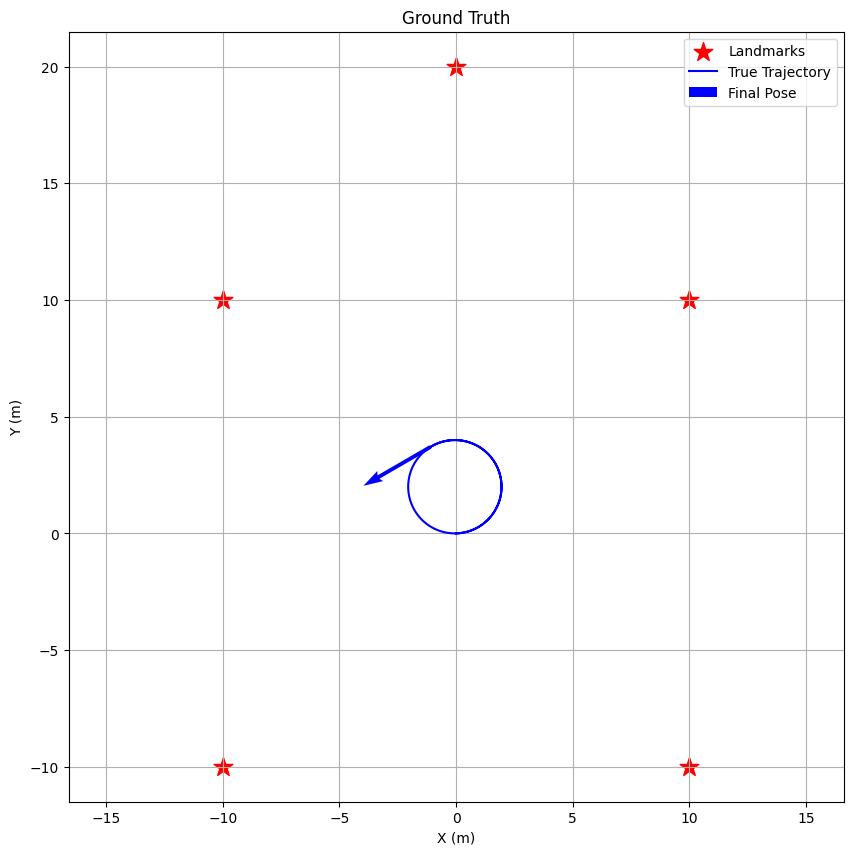

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1.1. Definition of landmarks position ---
# These are our reference points in the world.

landmarks = np.array([
    [10.0,10.0],
    [10.0,-10.0],
    [-10.0,10.0],
    [-10.0,-10.0],
    [0,20.0]
])


# --- 1.2. Definition of the true trajectory of the robot (Ground truth) ---
# This is the perfect path that the robot follows.

# Simulation parameters
dt = 0.1  # time interval (seconds)
SIMULATION_TIME = 20.0  # total duration of the simulation
NUM_STEPS = int(SIMULATION_TIME / dt)  # total number of simulation steps

# Trajectory storage
true_path = np.zeros((NUM_STEPS , 3))  # each line is [x , y , theta]
# initial position is (0 , 0 , 0)

# Constant control commands to create a circular trajectory
v = 1.0  # constant linear velocity (m/s)
omega = 0.5  # constant angular velocity (rad/s)

# Trajectory generation step by step
for t in range (1, NUM_STEPS):

  # Recover precedent position
  prev_x, prev_y, prev_theta = true_path[t-1]

  # Apply perfect cinematic movement model
  theta = prev_theta + omega * dt
  x = prev_x + v * np.cos(theta) * dt
  y = prev_y + v * np.sin(theta) * dt

  # Stock new true position
  true_path[t] = [x,y,theta]


  # --- 1.3. Simulation of the captors'perfect measures ---

  def get_true_measurement(robot_pose , landmarks) :

    """
    Calculate the perfect distance and angle of the robot to each landmarks
    """

    measurements = []
    rx , ry , rtheta = robot_pose

    for landmark in landmarks :
      lx, ly = landmark

      # Euclidean distance
      dist = np.sqrt((lx - rx)**2 + (ly - ry)**2)

      # Angle to the landmark
      angle_to_landmark = np.arctan2(ly - ry, lx - rx)

      # Angle of the robot orientation (Bearing)
      bearing = angle_to_landmark - rtheta

      # Normalization of the bearing angle so it is in [-pi , +pi]
      bearing = (bearing + np.pi) % (2 * np.pi) - np.pi

      measurements.append([dist , bearing])

    return np.array(measurements)


# --- 1.4. Visualisation du monde simulé ---

def plot_world(path , lanfdmarks) :
  plt.figure(figsize=(10, 10))
  plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='*', s=200, color='red', label='Landmarks')
  plt.plot(path[:, 0], path[:, 1], 'b-', label='True Trajectory')

  # Draw an arrow to show final orientation of the robot
  final_pose = path[-1]
  plt.quiver(final_pose[0], final_pose[1], np.cos(final_pose[2]), np.sin(final_pose[2]),
               color='blue', scale=10, width=0.005, label='Final Pose')

  plt.xlabel('X (m)')
  plt.ylabel('Y (m)')
  plt.title('Ground Truth')
  plt.grid(True)
  plt.axis('equal')
  plt.legend()
  plt.show()

# Display the world
plot_world(true_path , landmarks)

# **Step 2 : Uncertainties modelisation**
# Objective

Make our simulation as much realist as possible. In real life, actions and perceptions of the robot are imperfect. We will simulate these imperfections by introducing two types of *Gaussian noises* :



*   *Movement noise (on controls)* : Motors are not perfect. When a speed control is sent to the robot, it doesnt execute it perfectly. This provokes a position drift (the position which is estimated by odometry). We will simulate this by adding noises to the speed commands 𝑣 and ω.
*   *Measure noise (on captors)* : captors such as lasers, camera are not perfect. They provide measures with a certain amount of error. We will simulate this by adding noise to distance and angle measures to landmarks.

# What we will generate
In the end *(good music :p)*, we will end up with :


*   The true trajectory of *Step1*
*   *Odometric trajectory* : This is the trajectory that the robot thinks he moves along which is calculated with its noisy movement commands. We expect this trajectory to drift away from the true trajectory.
*  *Noisy measures* : Theses are the information that the filter will really receive from the environment.

Our filter job is to rebuild as close as possible the true trajectory with two information : the odometric trajectory and noisy measures.






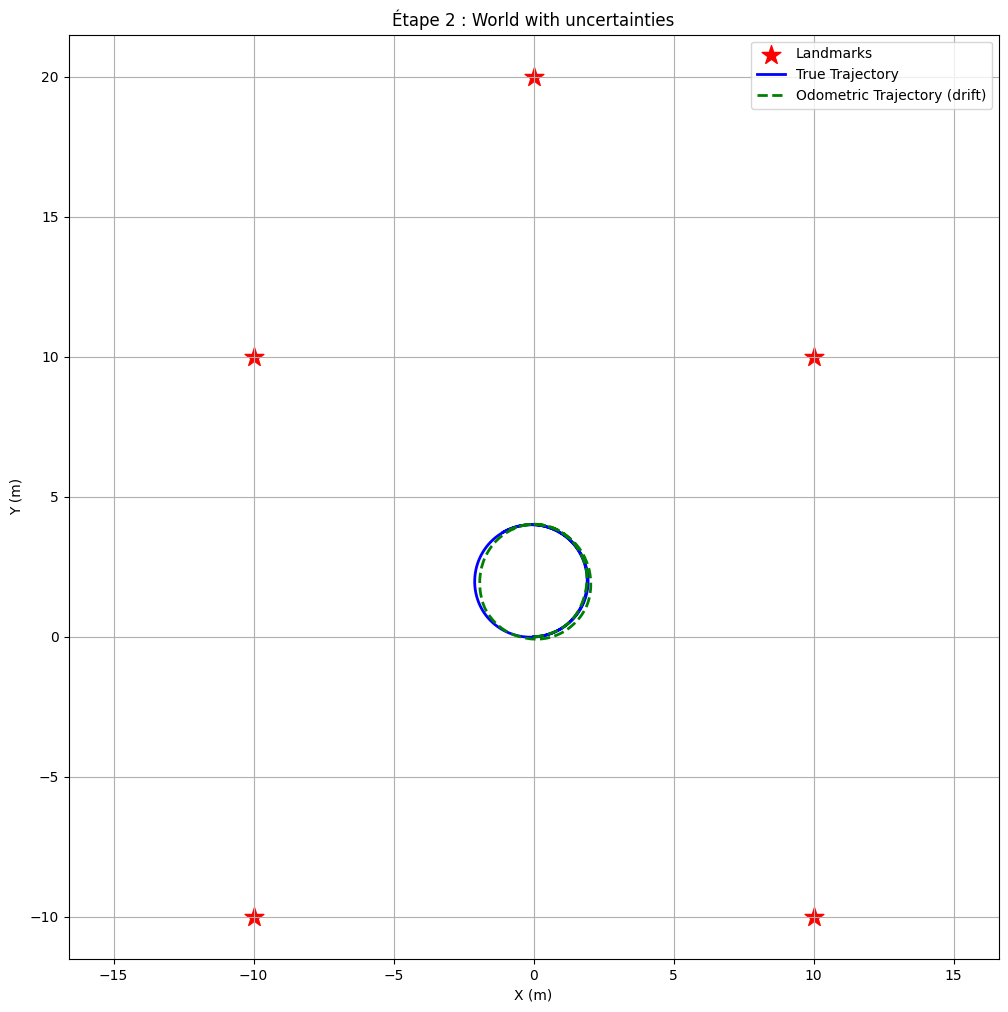

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1.1. Definition of landmarks position (from Step1) ---

landmarks = np.array([
    [10.0,10.0],
    [10.0,-10.0],
    [-10.0,10.0],
    [-10.0,-10.0],
    [0,20.0]
])

dt = 0.1
SIMULATION_TIME = 20.0
NUM_STEPS = int(SIMULATION_TIME / dt)
v_ideal = 1.0
omega_ideal = 0.5

# --- 2. Definition of noisy models ---
#  Standard deviation of the Gaussian noise

MOTION_NOISE_STD = np.array([0.05 , 0.02])    # Noise on [v , omega]
MEASUREMENT_NOISE_STD = np.array([0.2 , 0.05])    # Noise on [distance , angle]

# --- 3. Generation of trajectories (True and Odometric) ---

true_path = np.zeros((NUM_STEPS , 3))
odometry_path = np.zeros((NUM_STEPS , 3))

for t in range (1 , NUM_STEPS) :

  # Simulate true commands affected by noise

  v_true_execution = v_ideal + np.random.randn() * MOTION_NOISE_STD[0]
  omega_true_execution = omega_ideal + np.random.randn() * MOTION_NOISE_STD[1]

  # Update true trajectory by using true execution commands

  prev_pose_true = true_path[t-1]
  theta_true = prev_pose_true[2] + omega_true_execution * dt

  true_path[t] = [
      prev_pose_true[0] + v_true_execution * np.cos(theta_true) * dt,
      prev_pose_true[1] + v_true_execution * np.sin(theta_true) * dt,
      theta_true
  ]

  # UPDATE ODOMETRIC TRAJECTORY

  # Odometry is the sum of the movements the robot thinks he has done.
  # We simulate that the odometry is measuring commands with its own amount of error.

  v_odom_measured = v_ideal + np.random.randn() * MEASUREMENT_NOISE_STD[0]
  omega_odom_measured = omega_ideal + np.random.randn() * MEASUREMENT_NOISE_STD[1]

  prev_pose_odom = odometry_path[t-1]
  theta_odom = prev_pose_odom[2] + omega_odom_measured * dt

  odometry_path[t] = [
      prev_pose_odom[0] + v_odom_measured * np.cos(theta_odom) * dt,
      prev_pose_odom[1] + v_odom_measured * np.sin(theta_odom) * dt,
      theta_odom
  ]

# --- 4. Function to generate noisy measures ---

def get_noisy_measurement(robot_pose , landmarks) :
  measurement = []
  rx , ry , rtheta = robot_pose

  for landmark in landmarks :
    lx , ly = landmark
    dist = np.sqrt((lx - rx)**2 + (ly - ry)**2)
    bearing = np.arctan2(ly - ry , lx - rx)

    noisy_dist = dist + np.random.randn() * MEASUREMENT_NOISE_STD[0]
    noisy_bearing = bearing + np.random.randn() * MEASUREMENT_NOISE[1]
    noisy_bearing = (noisy_bearing + np.pi) % (2 * np.pi) - np.pi

    measurement.append([noisy_dist , noisy_bearing])

  return np.array(measurement)

# --- 5. Visualization of Step2 results ---

def plot_noisy_world(true_path, odometry_path, landmarks):
    plt.figure(figsize=(12, 12))
    plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='*', s=200, color='red', label='Landmarks')
    plt.plot(true_path[:, 0], true_path[:, 1], 'b-', linewidth=2, label='True Trajectory')
    plt.plot(odometry_path[:, 0], odometry_path[:, 1], 'g--', linewidth=2, label='Odometric Trajectory (drift)')

    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Étape 2 : World with uncertainties')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()

# Display
plot_noisy_world(true_path, odometry_path, landmarks)

# **Step 3 : Initialization of the filter's data structures**
# Objective

We will set up the fundamental matrices which will represent our filter's belief at each instant. In a Kalman filter, this belief is represented with a multidimensional Gaussian distribution which is defined as follows :


1.   ***Mean state vector (μ)*** : This is the best state estimation. It contains the most likely values of the robot and landmarks positions.
2.   ***Covariance matrix (Σ)*** : This is the monitoring core of incertainty. It quantifies uncertainty on each state variable and also correlations between uncertainties.
# Initialization

In the beginning (𝑡 = 0), the robot doesn't know the map.


*   The state vector **μ** only contains the initial pose of the robot (𝑥, 𝑦, θ). Its size is 3x1.
*   The covariance matrix **Σ** represents the uncertainty of this initial pose. Its size is 3x3. We will initialize it with zero uncertainty (a matrix full of zero) because we assume that the reobot knows perfectly its starting position.

As the robot discovers new landmarks, we will dynamically increase sizes of **μ** and **Σ**.





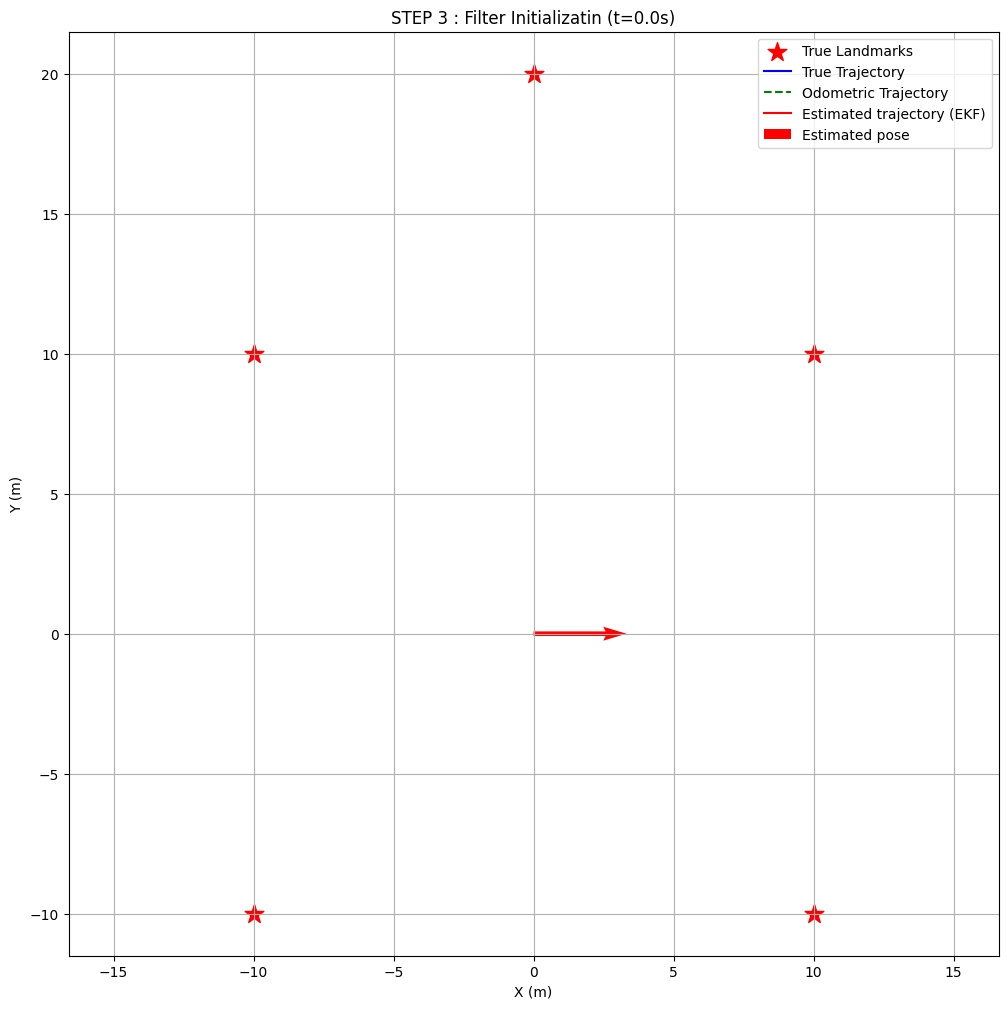

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math

# --- 1.1. Definition of landmarks position (from Step1) ---

landmarks = np.array([
    [10.0,10.0],
    [10.0,-10.0],
    [-10.0,10.0],
    [-10.0,-10.0],
    [0,20.0]
])

dt = 0.1
SIMULATION_TIME = 20.0
NUM_STEPS = int(SIMULATION_TIME / dt)
v_ideal = 1.0
omega_ideal = 0.5

# --- 2. Definition of noisy models (Unchanged) ---
#  Standard deviation of the Gaussian noise

MOTION_NOISE_STD = np.array([0.05 , 0.02])    # Noise on [v , omega]
MEASUREMENT_NOISE_STD = np.array([0.2 , 0.05])    # Noise on [distance , angle]

# --- 3. Generation of trajectories (True and Odometric) (Unchanged) ---

true_path = np.zeros((NUM_STEPS , 3))
odometry_path = np.zeros((NUM_STEPS , 3))

for t in range (1 , NUM_STEPS) :

  # Simulate true commands affected by noise

  v_true_execution = v_ideal + np.random.randn() * MOTION_NOISE_STD[0]
  omega_true_execution = omega_ideal + np.random.randn() * MOTION_NOISE_STD[1]

  # Update true trajectory by using true execution commands

  prev_pose_true = true_path[t-1]
  theta_true = prev_pose_true[2] + omega_true_execution * dt

  true_path[t] = [
      prev_pose_true[0] + v_true_execution * np.cos(theta_true) * dt,
      prev_pose_true[1] + v_true_execution * np.sin(theta_true) * dt,
      theta_true
  ]

  # UPDATE ODOMETRIC TRAJECTORY

  # Odometry is the sum of the movements the robot thinks he has done.
  # We simulate that the odometry is measuring commands with its own amount of error.

  v_odom_measured = v_ideal + np.random.randn() * MEASUREMENT_NOISE_STD[0]
  omega_odom_measured = omega_ideal + np.random.randn() * MEASUREMENT_NOISE_STD[1]

  prev_pose_odom = odometry_path[t-1]
  theta_odom = prev_pose_odom[2] + omega_odom_measured * dt

  odometry_path[t] = [
      prev_pose_odom[0] + v_odom_measured * np.cos(theta_odom) * dt,
      prev_pose_odom[1] + v_odom_measured * np.sin(theta_odom) * dt,
      theta_odom
  ]

# --- 4. Initialisation of the EKF filtre ---

# State vector mu. Size = 3x1. In the beginning = [x , y , theta]
mu = np.zeros((3 , 1))

# Covariance matrix Sigma. Size = 3x3. In the beginning, full of zeros because the robot is perfectly aware of the starting position.
Sigma = np.zeros((3 , 3))

# History of estimations for the final plot
mu_history = [mu.copy()]
Sigma_history = [Sigma.copy()]

# --- 4. Upgraded functions for visualization ---

def plot_covariance_ellipse(mu_xy, sigma_xy, ax, color='r'):
    """Draws an uncertainty ellipse in 2D."""
    eigenvalues, eigenvectors = np.linalg.eig(sigma_xy)
    angle = math.degrees(math.atan2(*eigenvectors[:, 0][::-1]))
    # 5.991 corresponds to a 95% confidence interval for a Chi-squared distribution with 2 degrees of freedom.
    width, height = 2 * np.sqrt(5.991 * eigenvalues)
    ellipse = Ellipse(xy=mu_xy, width=width, height=height, angle=angle,
                      edgecolor=color, facecolor='none', alpha=0.6, linewidth=2)
    ax.add_patch(ellipse)



def plot_state(true_path, odometry_path, mu_history, Sigma_history, landmarks, step):
    """Displays the whole stateof a system at a given time."""
    mu = mu_history[step]
    Sigma = Sigma_history[step]

    fig, ax = plt.subplots(figsize=(12, 12))

    # Landmarks
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='*', s=200, color='red', label='True Landmarks')

    # Trajectories
    ax.plot(true_path[:step+1, 0], true_path[:step+1, 1], 'b-', label='True Trajectory')
    ax.plot(odometry_path[:step+1, 0], odometry_path[:step+1, 1], 'g--', label='Odometric Trajectory')

    # Extract and draw the history of estimated positions
    est_path = np.array([h[:2, 0] for h in mu_history[:step+1]])
    ax.plot(est_path[:, 0], est_path[:, 1], 'r-', label='Estimated trajectory (EKF)')

    # Current estimated state of the robot
    robot_pose_est = mu[0:3]
    ax.quiver(robot_pose_est[0], robot_pose_est[1], np.cos(robot_pose_est[2]), np.sin(robot_pose_est[2]),
              color='r', scale=10, width=0.005, label='Estimated pose')

    # Robot uncertainty
    plot_covariance_ellipse(mu[0:2, 0], Sigma[0:2, 0:2], ax, color='r')

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(f'STEP 3 : Filter Initializatin (t={(step)*dt:.1f}s)')
    ax.grid(True)
    ax.axis('equal')
    ax.legend()
    plt.show()


# --- 5. Execution ---
# For the moment, we don't have any for loop, so we visualize only the value when t=0
# History contains only one element for the moment
plot_state(true_path, odometry_path, mu_history, Sigma_history, landmarks, step=0)
